In [1]:
# sys, file and nav packages:
import datetime as dt

# math packages:
import pandas as pd
import numpy as np
from scipy import stats
from statsmodels.distributions.empirical_distribution import ECDF

# charting:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.gridspec import GridSpec
import seaborn as sns

# home brew utitilties
import resources.utility_functions as ut
import resources.abundance_classes as ac
import resources.chart_kwargs as ck

import resources.sr_ut as sut

# images and display
import base64, io, IPython
from PIL import Image as PILImage
from IPython.display import Markdown as md
from IPython.display import display, Math, Latex


# set some parameters:
today = dt.datetime.now().date().strftime("%Y-%m-%d")
start_date = '2020-03-01'
end_date ='2021-05-31'

a_fail_rate = 50

unit_label = 'p/100m'
reporting_unit = 100

# name of the output folder:
name_of_project = 'lake_report_bielersee'

a_color = 'dodgerblue'

# colors for gradients
colors = ['beige', 'navajowhite', 'sandybrown', 'salmon', 'sienna']
nodes = [0.0, 0.2, 0.6, 0.8, 1.0]
cmap2 = LinearSegmentedColormap.from_list("mycmap", list(zip(nodes, colors)))

# set the maps
bassin_map = PILImage.open("resources/maps/leman_scaled.jpeg")
# land_use_map = PILImage.open("resources/maps/land_use_aare.jpeg")

# top level aggregation
top = "All survey areas"

# define the feature level and components
this_feature = {'slug':'lac-leman', 'name':"Lac Léman", 'level':'water_name_slug'}
this_level = 'city'
this_bassin = 'rhone'
bassin_label = 'Rhône survey area'

# explanatory variables:
luse_exp = ['% to buildings', '% to recreation', '% to agg', '% to woods', 'streets km', 'intersects']

# columns needed
use_these_cols = ['loc_date' ,
                  '% to buildings',
                  '% to trans', 
                  '% to recreation',
                  '% to agg',
                  '% to woods',
                  'population',
                  this_level,
                  'streets km',
                  'intersects',
                  'length',
                  'groupname',
                  'code'
                 ]

# add the folder to the directory tree:
project_directory = ut.make_project_folder('output', name_of_project)

# get your data:
river_bassins = ut.json_file_get("resources/river_basins.json")
dfBeaches = pd.read_csv("resources/beaches_with_land_use_rates.csv")
dfCodes = pd.read_csv("resources/codes_with_group_names_2015.csv")
dfDims = pd.read_csv("resources/corrected_dims.csv")

# set the index of the beach data to location slug
dfBeaches.set_index('slug', inplace=True)

# map location slug to the proper city name
city_map = dfBeaches['city']

# map locations to feature names
location_wname_key = dfBeaches.water_name_slug

# map water_name_slug to water_name
wname_wname = dfBeaches[['water_name_slug','water_name']].reset_index(drop=True).drop_duplicates()
wname_wname.set_index('water_name_slug', inplace=True)

# set the names of the components or the children of this_feature
comp_names = wname_wname.copy()

# a convenenience function to test Spearmans Rho on subssets of the data
def make_plot_with_spearmans(data, ax, n):
    """Gets Spearmans ranked correlation and make A/B scatter plot. Must proived a
    matplotlib axis object.
    """    
    sns.scatterplot(data=data, x=n, y=unit_label, ax=ax, color='black', s=30, edgecolor='white', alpha=0.6)
    corr, a_p = stats.spearmanr(data[n], data[unit_label])
    
    return ax, corr, a_p

# make any adjustments to code definitions here:
dfCodes.set_index("code", inplace=True)       

# these descriptions need to be shortened for display
dfCodes = sut.shorten_the_value(["G74", "description", "Insulation foams"], dfCodes)
dfCodes = sut.shorten_the_value(["G940", "description", "Foamed EVA for crafts and sports"], dfCodes)
dfCodes = sut.shorten_the_value(["G96", "description", "Sanitary-pads/tampons, applicators"], dfCodes)
dfCodes = sut.shorten_the_value(["G178", "description", "Metal bottle caps and lids"], dfCodes)
dfCodes = sut.shorten_the_value(["G82", "description", "Expanded foams 2.5cm - 50cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G81", "description", "Expanded foams .5cm - 2.5cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G117", "description", "Expanded foams < 5mm"], dfCodes)
dfCodes = sut.shorten_the_value(["G75", "description", "Plastic/foamed polystyrene 0 - 2.5cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G76", "description", "Plastic/foamed polystyrene 2.5cm - 50cm"], dfCodes)
dfCodes = sut.shorten_the_value(["G24", "description", "Plastic lid rings"], dfCodes)
dfCodes = sut.shorten_the_value(["G33", "description", "Lids for togo drinks plastic"], dfCodes)
dfCodes = sut.shorten_the_value(["G3", "description", "Plastic bags, carier bags"], dfCodes)
dfCodes = sut.shorten_the_value(["G204", "description", "Bricks, pipes not plastic"], dfCodes)

# make a map to the code descriptions
code_description_map = dfCodes.description

# make a map to the code materials
code_material_map = dfCodes.material

(leman)=
# Lac Léman

*Map of survey locations April 2020 - May 2021*

*Marker diameter = the median survey result in pieces of trash per 100 meters (p/100m).*

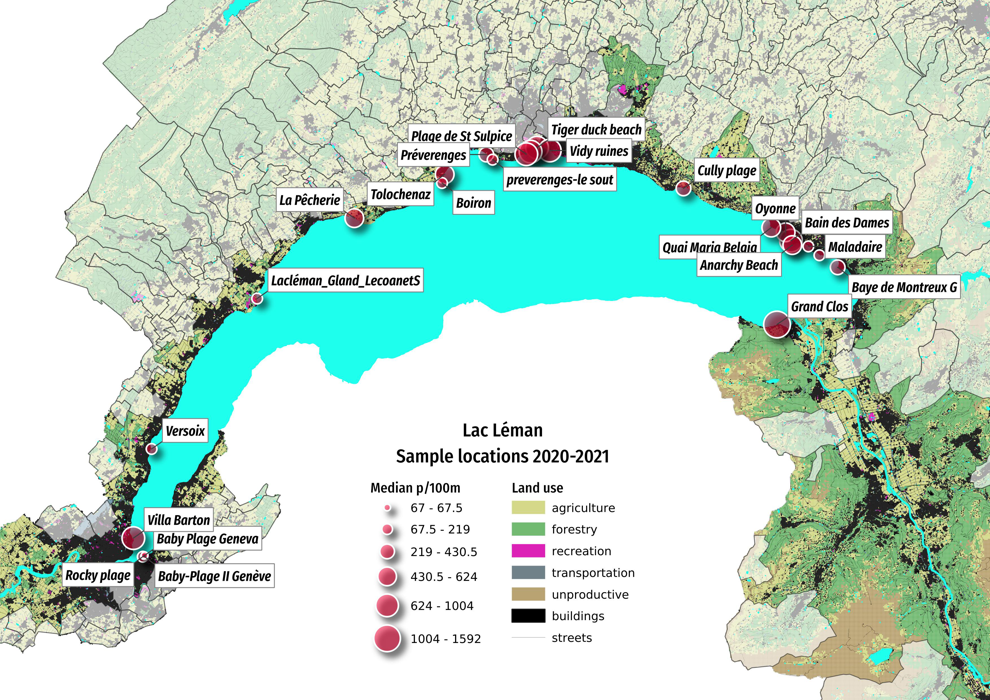

In [2]:
output = io.BytesIO()
bassin_map.thumbnail((1200,700))
bassin_map.save(output, format='PNG')
encoded_string = base64.b64encode(output.getvalue()).decode()

html = '<img src="data:image/png;base64,{}"/>'.format(encoded_string)
md(html)

## Sample locations and land use characteristics

In [3]:
# this is the data before the expanded fragmented plastics and foams are aggregated to Gfrags and Gfoams
before_agg = pd.read_csv("resources/checked_before_agg_sdata_eos_2020_21.csv")

# this is the aggregated survey data that is being used
a_data = pd.read_csv(F"resources/checked_sdata_eos_2020_21.csv")
fd = a_data[a_data[this_feature['level']] == this_feature['slug']].copy()
fd['loc_dates'] = list(zip(fd.location.values, fd.date.values))
fd['date'] = pd.to_datetime(fd.date)

material_totals = fd.groupby('material').quantity.sum()
code_totals = fd.groupby(['code', 'groupname'], as_index=False).agg({unit_label:'median', 'quantity':'sum'})

# cumulative statistics for each code
code_totals["% of total"] = ((code_totals.quantity/code_totals.quantity.sum())*100).round(2)
code_totals["fail"] = code_totals.code.map(lambda x: fd[(fd.code == x) & (fd.quantity > 0)].loc_date.nunique())
code_totals["fail rate"] = ((code_totals.fail/fd.loc_date.nunique())*100).astype('int')
code_totals.set_index('code', inplace=True)
code_totals['material'] = code_totals.index.map(lambda x: code_material_map[x])
code_totals['item'] = code_totals.index.map(lambda x: code_description_map[x])

# daily survey totals
dt_all = fd.groupby(['loc_date','location',this_level, 'date'], as_index=False).agg({unit_label:'sum', 'quantity':'sum'})

# gather the municpalities and the population:
fd_pop_map = dfBeaches.loc[fd.location.unique()][['city','population']].copy()
fd_pop_map.drop_duplicates(inplace=True)
fd_pop_map.set_index('city', drop=True, inplace=True)

# material totals
fd_mat_t = code_totals[['material', 'quantity']].groupby('material', as_index=False).quantity.sum()
fd_mat_t["% of total"] = fd_mat_t.quantity/fd_mat_t.quantity.sum()

# material table for display
fd_mat_totals = fd_mat_t.sort_values(by='quantity', ascending=False)
cols_to_use = {'material':'Material','quantity':'Quantity', '% of total':'% of total'}

# format columns for material table
fd_mat_totals['% of total'] =(fd_mat_totals['% of total']*100).round(1)
fd_mat_totals['quantity']=fd_mat_totals.quantity.map(lambda x: '{:,}'.format(x))
fd_mat_totals['% of total']=fd_mat_totals['% of total'].map(lambda x:F"{x}%")
fd_mat_t = fd_mat_totals[cols_to_use.keys()].values

# summary statistics:
# number of samples
fd_n_samps = len(dt_all)
# quantity
fd_n_obj = fd.quantity.sum()
# number of locations
fd_n_locs = fd.location.nunique()
# number of cities
fd_n_munis = len(fd_pop_map.index)
# populations
fd_effected_population = fd_pop_map.sum()
# list of locations
fd_locs = fd.location.unique()
# list of survey keys
fd_samps = fd.loc_date.unique()

lakes = dfBeaches.loc[(dfBeaches.index.isin(fd_locs))&(dfBeaches.water == 'l')]['water_name'].unique()
rivers = dfBeaches.loc[(dfBeaches.index.isin(fd_locs))&(dfBeaches.water == 'r')]['water_name'].unique()

obj_string = '{:,}'.format(fd_n_obj)
surv_string = '{:,}'.format(fd_n_samps)
pop_string = '{:,}'.format(int(fd_effected_population[0]))

date_quantity_context = F"For the period between {start_date[:-3]} and {end_date[:-3]}, {obj_string } objects were removed and identified in the course of {surv_string} surveys."
geo_context = F"Those surveys were conducted at {fd_n_locs} different locations."
admin_context = F"There are {fd_n_munis} different municipalities represented in these results with a combined population of approximately {pop_string}."
munis_joined = ', '.join(sorted(fd_pop_map.index))
lakes_joined = ', '.join(sorted(lakes))
rivers_joined = ', '.join(sorted(rivers))

# put that all together:
lake_string = F"""
{date_quantity_context} {geo_context } {admin_context}

*The municipalities in this report:*\n\n{munis_joined}
"""
md(lake_string)


For the period between 2020-03 and 2021-05, 27,462 objects were removed and identified in the course of 98 surveys. Those surveys were conducted at 24 different locations. There are 13 different municipalities represented in these results with a combined population of approximately 443,854.

*The municipalities in this report:*

Allaman, Bourg-en-Lavaux, Genève, Gland, La Tour-de-Peilz, Lausanne, Montreux, Préverenges, Saint-Gingolph, Saint-Sulpice (VD), Tolochenaz, Versoix, Vevey


### Cumulative totals by municipality

In [4]:
# map the qauntity to the dimensional data
q_map = fd.groupby(this_level).quantity.sum()

# gather the dimensional data for the time frame from dfDims
fd_dims= dfDims[(dfDims.location.isin(fd_locs))&(dfDims.date >= start_date)&(dfDims.date <= end_date)].copy()
fd_dims['loc_dates'] = list(zip(fd_dims.location.values, fd_dims.date.values))
fd_dims['city'] = fd_dims.location.map(lambda x: city_map.loc[x])

# aggregate the dimensional data 
dims_table = fd_dims.groupby([this_level]).agg({'total_w':'sum', 'mac_plast_w':'sum', 'area':'sum', 'length':'sum'})

# collect the number of samples from the survey total data:
for name in dims_table.index:
    dims_table.loc[name, 'samples'] = fd[fd[this_level] == name].loc_date.nunique()
    dims_table.loc[name, 'quantity'] = q_map[name]

# get the sum of all survey areas
dims_table.loc[this_feature['name']]= dims_table.sum(numeric_only=True, axis=0)

# for display
dims_table.sort_values(by=["quantity"], ascending=False, inplace=True)
dims_table.rename(columns={'samples':'samples','quantity':'items', 'total_w':'total kg', 'mac_plast_w':'plastic kg', 'area':'m²', 'length':'meters'}, inplace=True)

# format kilos
dims_table['plastic kg'] = dims_table['plastic kg']/1000

# figure caption
agg_caption = F"""
*{this_feature['name']}: table of results. The cumulative weights and measures for the water feature and municipalities*
"""
md(agg_caption)


*Lac Léman: table of results. The cumulative weights and measures for the water feature and municipalities*


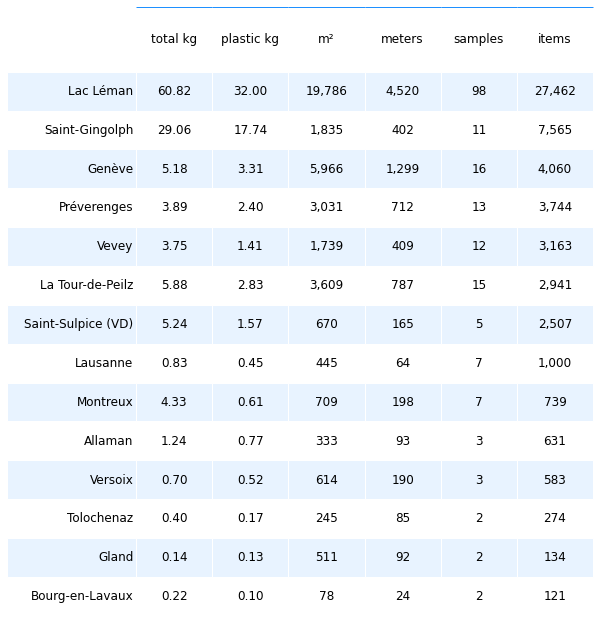

In [5]:
# row shading for chart
a_color='dodgerblue'

# format the aggregated dimensional data for printing
dims_table[["m²", "meters", "samples", "items"]] = dims_table[["m²", "meters", "samples", "items"]].applymap(lambda x: '{:,}'.format(int(x)))
dims_table[['plastic kg', 'total kg']] = dims_table[['plastic kg', 'total kg']].applymap(lambda x: '{:.2f}'.format(x))

# make table
data = dims_table.reset_index()

fig, axs = plt.subplots(figsize=(len(data.columns)*1.5,len(data)*.8))
ut.hide_spines_ticks_grids(axs)

the_first_table_data = axs.table(data.values,  colLabels=data.columns, colWidths=[.22, *[.13]*6], bbox=[0, 0, 1, 1])

a_summary_table_one = sut.make_a_summary_table(the_first_table_data,data.values,data.columns, a_color, s_et_bottom_row=False)

a_summary_table_one.get_celld()[(0,0)].get_text().set_text(" ")

plt.show()
plt.tight_layout()
plt.close()

## Survey results all objects

Survey totals by date and monthly or quarterly median for all surveys. The empirical cumulative distribution of all survey results for the lake.

In [6]:
# the surveys to chart
fd_dindex = dt_all.set_index('date')

# only the surveys from all other survey areas
a_data['date'] = pd.to_datetime(a_data.date)
dts_date = a_data[~a_data[this_feature['level']].isin(fd[this_feature['level']].unique())].copy()
dts_date = dts_date.groupby(['loc_date','date'], as_index=False)[unit_label].sum()

dts_date.set_index('date', inplace=True)

# samples were taken quarterly in ticino
if this_feature['name'] == 'ticino':
    monthly_plot = fd_dindex[unit_label].resample('Q').median()
    rate = "Quarterly"
else:
    monthly_plot = fd_dindex[unit_label].resample('M').median()
    rate = "Monthly"

# scale the chart as needed to accomodate for extreme values
scale_back = 98

# the results gets applied to the y_limit function in the chart
the_90th = np.percentile(dts_date[unit_label], scale_back)
not_included = F"Values greater than {round(the_90th, 1)}{unit_label} {scale_back}% not shown."

# figure caption
chart_notes = F"""
*__Left:__ {this_feature['name']}, {start_date[:7]} through {end_date[:7]}, n={fd_n_samps}. {not_included}*
"""
md(chart_notes )


*__Left:__ Lac Léman, 2020-03 through 2021-05, n=98. Values greater than 1054.8p/100m 98% not shown.*


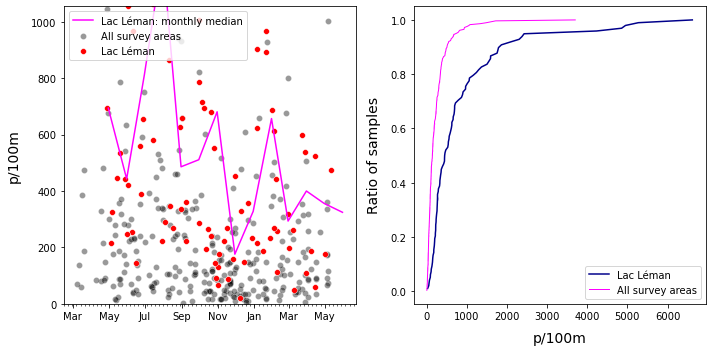

In [7]:
# months locator, can be confusing
# https://matplotlib.org/stable/api/dates_api.html
months = mdates.MonthLocator(interval=1)
months_fmt = mdates.DateFormatter('%b')
days = mdates.DayLocator(interval=7)

fig, axs = plt.subplots(1,2, figsize=(10,5))

ax = axs[0]

sns.scatterplot(data=dts_date, x=dts_date.index, y=unit_label, label="All survey areas", color='black', alpha=0.4,  ax=ax)
sns.scatterplot(data=fd_dindex, x=fd_dindex.index, y=unit_label, label=this_feature['name'], color='red', s=34, ec='white', ax=ax)

sns.lineplot(data=monthly_plot, x=monthly_plot.index, y=monthly_plot, label=F"{this_feature['name']}: monthly median", color='magenta', ax=ax)

ax.set_ylim(0,the_90th )

ax.set_xlabel("")
ax.set_ylabel(unit_label, **ck.xlab_k14)

ax.xaxis.set_minor_locator(days)
ax.xaxis.set_major_formatter(months_fmt)
ax.legend()

axtwo = axs[1]
    
a_ecdf = ECDF(dt_all[unit_label].values)
    
sns.lineplot(x=a_ecdf.x, y=a_ecdf.y, color="darkblue", ax=axtwo, label=this_feature['name'])

r_bassin = ECDF(dts_date[unit_label].values)
sns.lineplot(x=r_bassin.x, y=r_bassin.y, color='magenta', label=top, linewidth=1, ax=axtwo)
axtwo.set_xlabel(unit_label, **ck.xlab_k14)
axtwo.set_ylabel("Ratio of samples", **ck.xlab_k14)

plt.tight_layout()
plt.show()

In [8]:
# figure caption
lakes_ecdf = F"""
*__Right:__ {this_feature['name']} empirical cumulative distribution of survey results all survey areas*
"""
md(lakes_ecdf)


*__Right:__ Lac Léman empirical cumulative distribution of survey results all survey areas*


### Summary data and material types

In [9]:
# figure caption
summary_of_survey_totals = F"""
*__Left:__ {this_feature['name']} summary of survey totals*
"""
md(summary_of_survey_totals)


*__Left:__ Lac Léman summary of survey totals*


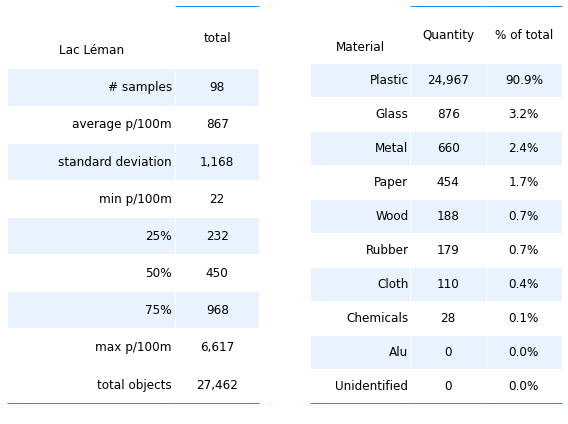

In [10]:
# the labels for the summary table:
change_names = {'count':'# samples', 
                'mean':F"average {unit_label}",
                'std':'standard deviation', 
                'min p/50m':'min', '25%':'25%',
                '50%':'50%', '75%':'75%',
                'max':F"max {unit_label}", 'min':F"min {unit_label}",
                'total objects':'total objects',
                '# locations':'# locations',
                'survey year':'survey year'
               }

# convenience function to change the index names in a series
def anew_dict(x):
    new_dict = {}
    for param in x.index:
        new_dict.update({change_names[param]:x[param]})
    return new_dict  

# select data
data = dt_all

# get the basic statistics from pd.describe
desc_2020 = data[unit_label].describe().round(2)

# add project totals
desc_2020['total objects'] = data.quantity.sum()
desc_2020['# locations'] = fd.location.nunique()

# change the names
combined_summary = pd.Series(anew_dict(desc_2020))

# format the output for printing:
not_formatted = combined_summary[-1]
combined_summary = [(x, "{:,}".format(int(combined_summary[x]))) for x in combined_summary.index[:-1]]
combined_summary.append((desc_2020.index[-1], int(not_formatted) ))

# make tables
fig, axs = plt.subplots(1,2, figsize=(8,6))

# summary table
# names for the table columns
a_col = [this_feature['name'], 'total']

axone = axs[0]
ut.hide_spines_ticks_grids(axone)

a_table = axone.table(cellText=combined_summary[:-1],  colLabels=a_col, colWidths=[.5,.25,.25], loc='lower center', bbox=[0,0,1,1])
the_material_table_data = sut.make_a_summary_table(a_table,combined_summary[:-1],a_col, s_et_bottom_row=True)

# material table
axtwo = axs[1]
axtwo.set_xlabel(" ")
ut.hide_spines_ticks_grids(axtwo)

# data to use
data = fd_mat_t.copy()

# column names for display
cols_to_use = {'material':'Material','quantity':'Quantity', '% of total':'% of total'}

a_table = axtwo.table(cellText=data,  colLabels=list(cols_to_use.values()), colWidths=[.4, .3,.3], loc='lower center', bbox=[0,0,1,1])
the_material_table_data = sut.make_a_summary_table(a_table,data,list(cols_to_use.values()), s_et_bottom_row=True)

plt.tight_layout()
plt.subplots_adjust(wspace=0.2)
plt.show()

In [11]:
# figure caption
material_type = F"""
*__Right:__ {this_feature['name']} material type and percent of total*
"""
md(material_type)


*__Right:__ Lac Léman material type and percent of total*


## The most common objects

The most common objects are **the ten most abundant by quantity found** AND/OR **any object that was indentified in at least 50% of all the surveys**. 

In [12]:
# the top ten by quantity
most_abundant = code_totals.sort_values(by='quantity', ascending=False)[:10]

# the most common
most_common = code_totals[code_totals["fail rate"] > 49.999].sort_values(by='quantity', ascending=False)

# merge with most_common and drop duplicates
m_common = pd.concat([most_abundant, most_common]).drop_duplicates()

# get percent of total
m_common_percent_of_total = m_common.quantity.sum()/code_totals.quantity.sum()

# figure caption
rb_string = F"""
*{this_feature['name']} most common objects: fail rate >/= {a_fail_rate}%  and/or top ten by quantity.*

*Combined, the most abundant objects represent {int(m_common_percent_of_total*100)}% of all objects found.*

Note : {unit_label} = median survey value.
"""
md(rb_string)


*Lac Léman most common objects: fail rate >/= 50%  and/or top ten by quantity.*

*Combined, the most abundant objects represent 82% of all objects found.*

Note : p/100m = median survey value.


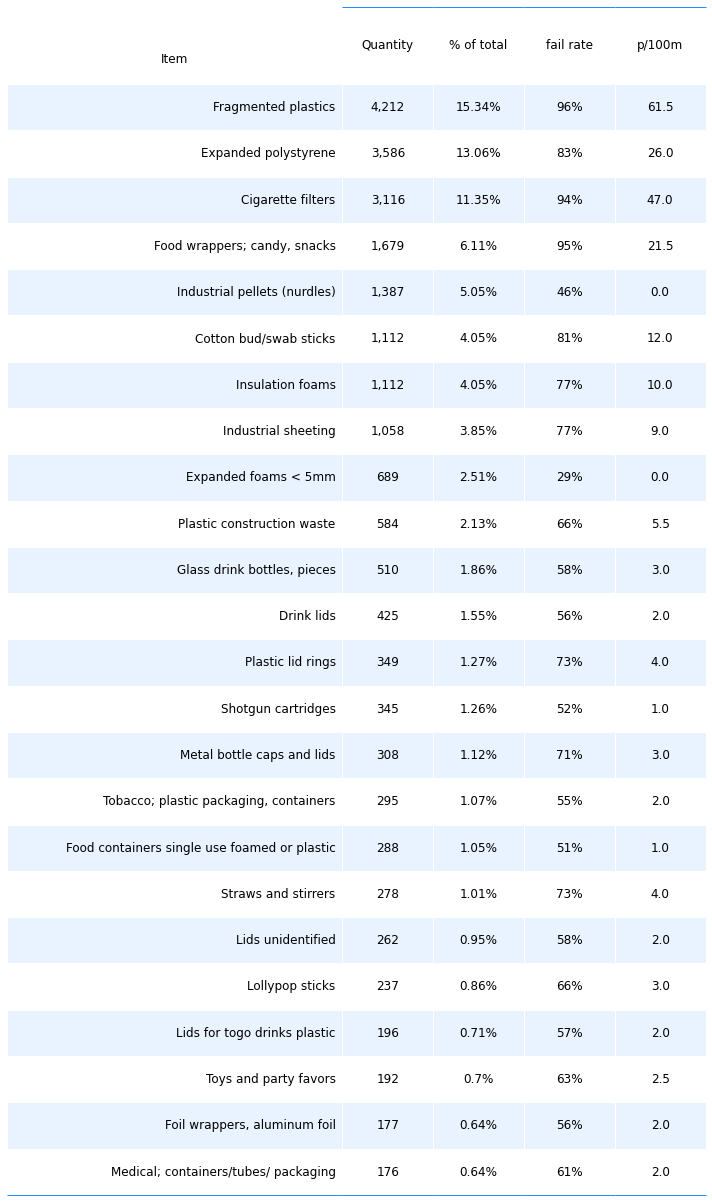

In [13]:
# format values for table
m_common['item'] = m_common.index.map(lambda x: code_description_map.loc[x])
m_common['% of total'] = m_common["% of total"].map(lambda x: F"{x}%")
m_common['quantity'] = m_common.quantity.map(lambda x: '{:,}'.format(x))
m_common['fail rate'] = m_common['fail rate'].map(lambda x: F"{x}%")
m_common[unit_label] = m_common[unit_label].map(lambda x: F"{round(x,1)}")

# final table data
cols_to_use = {'item':'Item','quantity':'Quantity', '% of total':'% of total', 'fail rate':'fail rate', unit_label:unit_label}
all_survey_areas = m_common[cols_to_use.keys()].values

fig, axs = plt.subplots(figsize=(10,len(m_common)*.7))

ut.hide_spines_ticks_grids(axs)

the_first_table_data = axs.table(all_survey_areas,  colLabels=list(cols_to_use.values()), colWidths=[.48, .13,.13,.13, .13], bbox=[0, 0, 1, 1])

a_summary_table_one = sut.make_a_summary_table(the_first_table_data,m_common,list(cols_to_use.values()), a_color)
plt.tight_layout()
plt.show()

plt.close()

### Most common objects results by municipality

In [14]:
rb_string = F"""
*{this_feature['name']} most common objects: median {unit_label}*

*All survey areas and samples*
"""
md(rb_string)


*Lac Léman most common objects: median p/100m*

*All survey areas and samples*


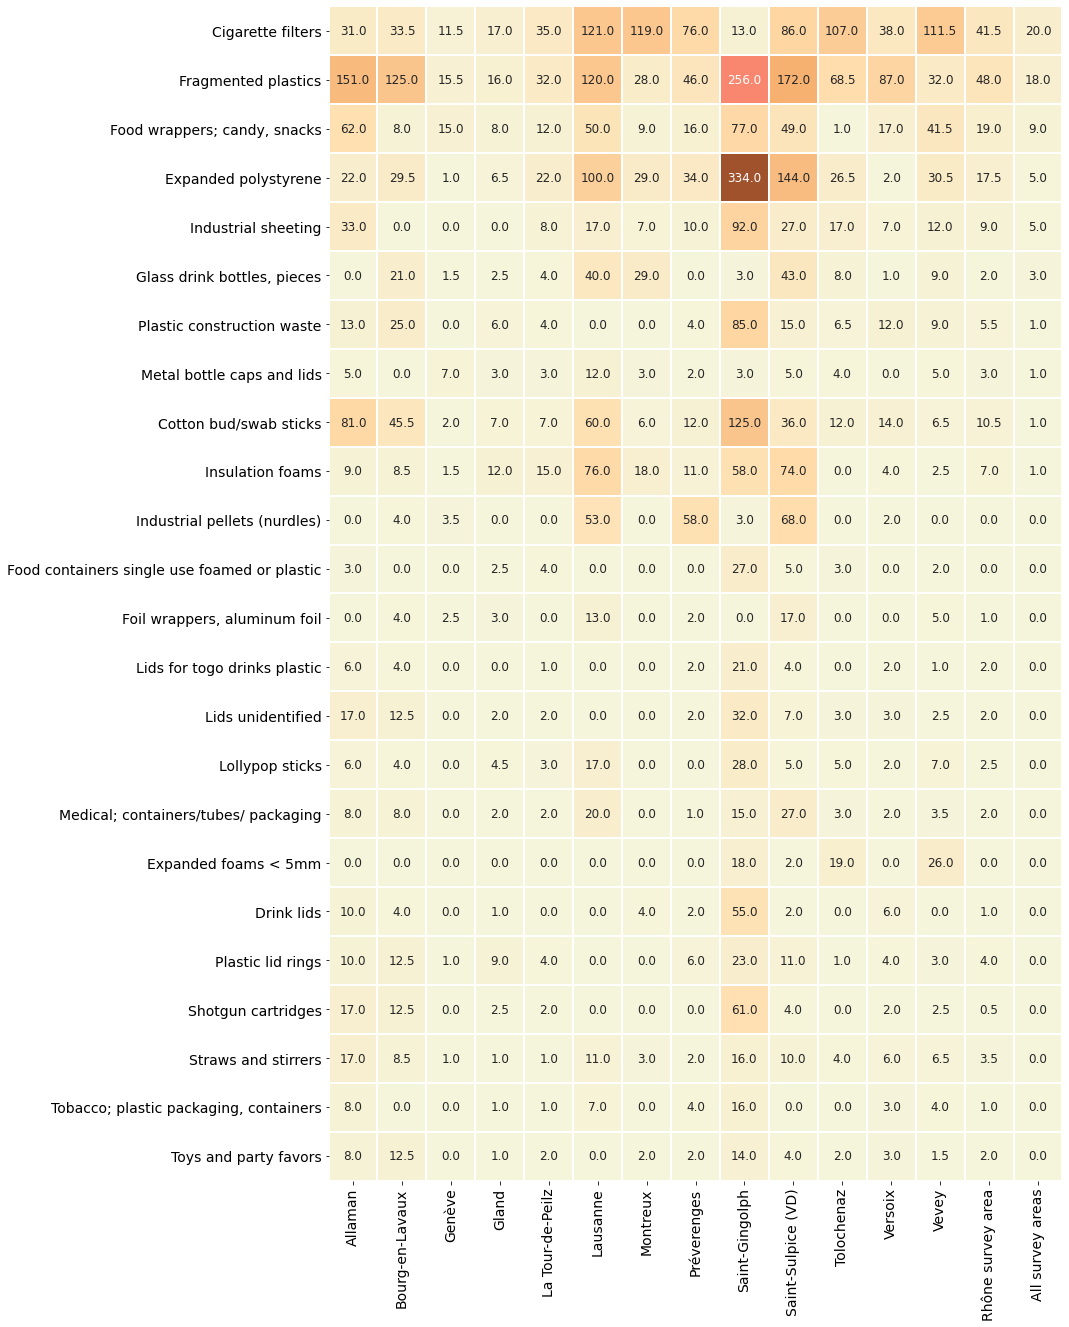

In [15]:
# aggregated survey totals for the most common codes for all the water features
# a common aggregation
agg_pcs_quantity = {unit_label:'sum', 'quantity':'sum'}

m_common_st = fd[fd.code.isin(m_common.index)].groupby([this_level, 'loc_date','code'], as_index=False).agg(agg_pcs_quantity)
m_common_ft = m_common_st.groupby([this_level, 'code'], as_index=False)[unit_label].median()

# proper name of water feature for display
m_common_ft['f_name'] = m_common_ft['city']

# map the desctiption to the code
m_common_ft['item'] = m_common_ft.code.map(lambda x: code_description_map.loc[x])

# pivot that
m_c_p = m_common_ft[['item', unit_label, 'f_name']].pivot(columns='f_name', index='item')
# quash the hierarchal column index
m_c_p.columns = m_c_p.columns.get_level_values(1)

# the aggregated totals for the river bassin
t_s_a = a_data[(a_data.code.isin(m_common.index))&(a_data.river_bassin == this_bassin)].groupby(['water_name_slug', 'loc_date','code'], as_index=False).agg(agg_pcs_quantity)
t_s_a = t_s_a.groupby('code', as_index=False)[unit_label].median()
t_s_a['item'] = t_s_a.code.map(lambda x: code_description_map.loc[x])
t_s_a.set_index('item', inplace=True)
t_s_a[bassin_label] = t_s_a[unit_label]

# repeat for all the survey areas
a_s_a = a_data[a_data.code.isin(m_common.index)].groupby(['water_name_slug', 'loc_date','code'], as_index=False).agg(agg_pcs_quantity)
a_s_a = a_s_a.groupby('code', as_index=False)[unit_label].median()
a_s_a['item'] = a_s_a.code.map(lambda x: code_description_map.loc[x])
a_s_a.set_index('item', inplace=True)
a_s_a[top] = a_s_a[unit_label]

ad_t_ten = pd.concat([m_c_p, t_s_a[bassin_label], a_s_a[top],], axis=1).sort_values(by=top, ascending=False)

# chart that
fig, ax  = plt.subplots(figsize=(len(ad_t_ten.columns)*.9,len(ad_t_ten)*.9))
axone = ax

sns.heatmap(ad_t_ten, ax=axone, cmap=cmap2, annot=True, annot_kws={"fontsize":12}, fmt=".1f", square=True, cbar=False, linewidth=.1, linecolor='white')

axone.set_ylabel("")
axone.tick_params(labelsize=14, which='both', axis='both')

plt.setp(axone.get_xticklabels(), rotation=90)

plt.show()
plt.close()

### Most common objects monthly average

In [16]:
# collect the survey results of the most common objects
m_common_m = fd[(fd.code.isin(m_common.index))].groupby(['loc_date','date','code', 'groupname'], as_index=False).agg(agg_pcs_quantity)
m_common_m.set_index('date', inplace=True)

# set the order of the chart, group the codes by groupname columns
an_order = m_common_m.groupby(['code','groupname'], as_index=False).quantity.sum().sort_values(by='groupname')['code'].values

# a manager dict for the monthly results of each code
mgr = {}

# get the monhtly results for each code:
for a_group in an_order:
    # resample by month
    a_plot = m_common_m[(m_common_m.code==a_group)][unit_label].resample('M').mean().fillna(0)
    this_group = {a_group:a_plot}
    mgr.update(this_group)

monthly_mc = F"""
*{this_feature['name']}, monthly average survey result {unit_label}*

*Detail of the most common objects*
"""
md(monthly_mc)


*Lac Léman, monthly average survey result p/100m*

*Detail of the most common objects*


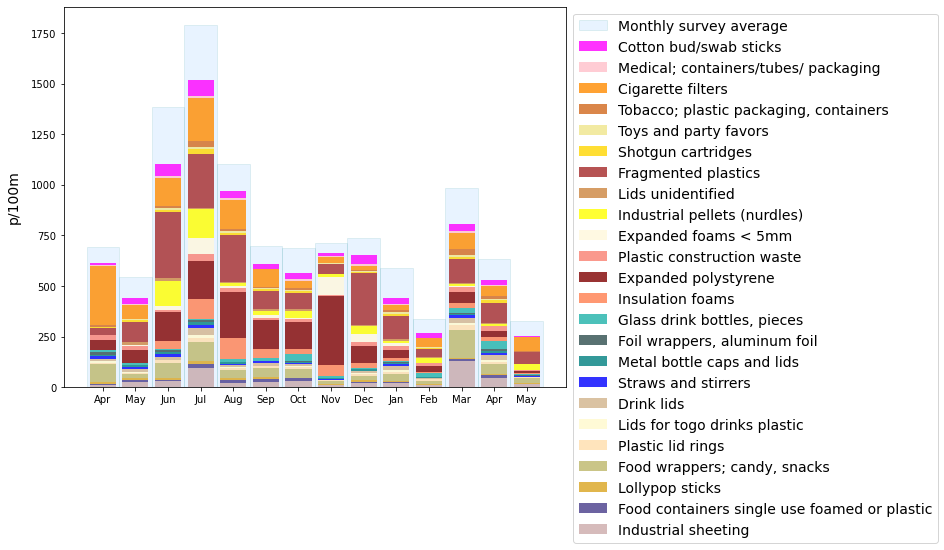

In [17]:
# color palette for the most common objects
colors_palette = {
    'G156':'dimgray', 'G178': 'teal',
    'G177': 'darkslategray',
    'G200': 'lightseagreen',
    'G27':'darkorange',
    'G30':'darkkhaki',
    'G67':'rosybrown',
    'G89': 'salmon',
    'G95':'magenta',
    'G82': 'maroon',
    'G79':'brown',
    'G208': 'turquoise',
    'G124':'indigo',
    'G25': 'chocolate',
    'G31': 'goldenrod',
    'G21':'tan',
    'Gfrags':'brown',
    'Gfoam':'maroon',
    'G117':'cornsilk',
    'G941':'plum',
    'G74':'coral',
    'G112': 'yellow',
    'G24':'navajowhite',
    'G23':'peru',
    'G100':'pink',
    'G32':'khaki',
    'G33':'lemonchiffon',
    'G35':'blue',
    'G211':'thistle',
    'G904':'lightgray',
    'G940':'tomato',
    'G106':'peru',
    'G10':'darkslateblue',
    'G70':'gold',
    
}
months={
    0:'Jan',
    1:'Feb',
    2:'Mar',
    3:'Apr',
    4:'May',
    5:'Jun',
    6:'Jul',
    7:'Aug',
    8:'Sep',
    9:'Oct',
    10:'Nov',
    11:'Dec'
}

# convenience function to lable x axis
def new_month(x):
    if x <= 11:
        this_month = x
    else:
        this_month=x-12    
    return this_month

fig, ax = plt.subplots(figsize=(9,7))

# define a bottom
bottom = [0]*len(mgr['G27'])

# the monhtly survey average for all objects and locations
monthly_fd = fd.groupby(['loc_date', 'date'], as_index=False).agg(agg_pcs_quantity)
monthly_fd.set_index('date', inplace=True)
m_fd = monthly_fd[unit_label].resample('M').mean().fillna(0)

# define the xaxis
this_x = [i for i,x in  enumerate(m_fd.index)]

# plot the monthly total survey average
ax.bar(this_x, m_fd.to_numpy(), color='dodgerblue', alpha=0.1, linewidth=1, edgecolor='teal', width=1, label="Monthly survey average") 

# plot the monthly survey average of the most common objects
for i, a_group in enumerate(an_order): 
    
    # define the axis
    this_x = [i for i,x in  enumerate(mgr[a_group].index)]
    
    # collect the month
    this_month = [x.month for i,x in enumerate(mgr[a_group].index)]
    
    # if i == 0 laydown the first bars
    if i == 0:
        ax.bar(this_x, mgr[a_group].to_numpy(), label=a_group, color=colors_palette[a_group], linewidth=1, alpha=0.6 ) 
    # else use the previous results to define the bottom
    else:
        bottom += mgr[an_order[i-1]].to_numpy()        
        ax.bar(this_x, mgr[a_group].to_numpy(), bottom=bottom, label=a_group, color=colors_palette[a_group], linewidth=1, alpha=0.8)
        
# collect the handles and labels from the legend
handles, labels = ax.get_legend_handles_labels()

# set the location of the x ticks
ax.xaxis.set_major_locator(ticker.FixedLocator([i for i in np.arange(len(this_x))]))
ax.set_ylabel(unit_label, **ck.xlab_k14)

# label the xticks by month
axisticks = ax.get_xticks()
labelsx = [months[new_month(x-1)] for x in  this_month]
plt.xticks(ticks=axisticks, labels=labelsx)

# make the legend
# swap out codes for descriptions
new_labels = [code_description_map.loc[x] for x in labels[1:]]
new_labels = new_labels[::-1]

# insert a label for the monthly average
new_labels.insert(0,"Monthly survey average")
handles = [handles[0], *handles[1:][::-1]]
    
plt.legend(handles=handles, labels=new_labels, bbox_to_anchor=(1, 1), loc="upper left",  fontsize=14)    
plt.show()

## Utility of the objects found

The utility type is based on the utilisation of the object prior to it being discarded. Objects that are found are placed into to one of the 260 categories. Those categories are grouped according to utilisation.

*  **wastewater**: items released from water treatment plants includes items likely toilet flushed   
*  **micro plastics (< 5mm)**: fragmented plastic items and pre-production plastic resins
*  **infrastructure**: items related to construction and maintenance of all infratructure items 
*  **food and drink**: primarily single use plastic items related to consuming food and drinks outdoors  
*  **agriculture**: primarily industrial sheeting includes mulch films
*  **tobacco**: primarily cigarette ends includes all smoking related material 
*  **recreation**: includes fishing, hunting, boating and beach related objects, excludes food, drink and tobacco items   
*  **packaging non food and drink**: packaging or wrapping material not identified as food, drink nor tobacco related  
*  **plastic fragments**: foam and plastic fragments of indeterminate origin and use 
*  **personal items**: accessories, hygiene and clothing related 

See the annex for the complete list of objects identified, includes description and group classification. The section [Code groups](codegroups) describes each code group in detail and provides a comprehensive list of all objects in a group.

In [18]:
cg_poft = F"""
<br></br>
{this_feature['name']} utility of objects found % of total by water feature. Fragmented objects with no clear identification remain classified by size:
"""
md(cg_poft)


<br></br>
Lac Léman utility of objects found % of total by water feature. Fragmented objects with no clear identification remain classified by size:


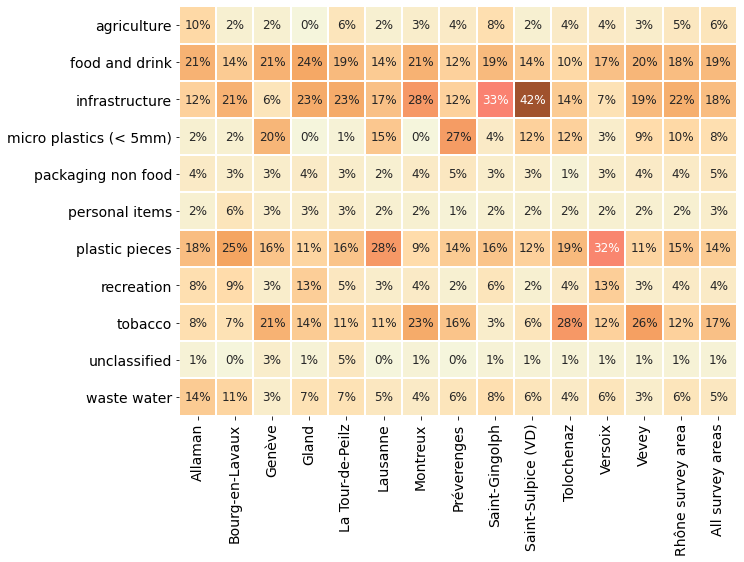

In [19]:
# code groups aggregated by survey for each survey area
cg_t = fd.groupby([this_level,'loc_date', 'groupname'], as_index=False).agg(agg_pcs_quantity)

# get the fail rates for each group per survey
cg_t['fail']=False
cg_t['fail'] = cg_t.quantity.where(lambda x: x == 0, True)

# aggregate all that for each survey area
cg_t = cg_t.groupby([this_level, 'groupname'], as_index=False).agg({unit_label:'median', 'quantity':'sum', 'fail':'sum', 'loc_date':'nunique'})

# quantity per water survey area
cg_tq = cg_t.groupby(this_level).quantity.sum()

# assign survey area total to each record
for a_feature in cg_tq.index:
    cg_t.loc[cg_t[this_level] == a_feature, 'f_total'] = cg_tq.loc[a_feature]

# get the percent of total for each group for each survey area
cg_t['pt'] = (cg_t.quantity/cg_t.f_total).round(2)

# pivot that
data_table = cg_t.pivot(columns=this_level, index='groupname', values='pt')

# add a column for the survey area totals and the national totals:
# repeat for the survey area
t_s_a = a_data[(a_data.river_bassin == this_bassin)].groupby(['loc_date','groupname'], as_index=False).agg(agg_pcs_quantity)
t_s_a = t_s_a.groupby('groupname', as_index=False).agg({unit_label:'median', 'quantity':'sum'})
t_s_a['pt'] = (t_s_a.quantity/t_s_a.quantity.sum()).round(2)
t_s_a.set_index('groupname', inplace=True)
t_s_a[bassin_label] = t_s_a['pt']

# repeat for all data
a_s_a = a_data.groupby(['water_name_slug', 'loc_date','groupname'], as_index=False).agg(agg_pcs_quantity)
a_s_a = a_s_a.groupby('groupname', as_index=False).agg({unit_label:'median', 'quantity':'sum'})
a_s_a['pt'] = (a_s_a.quantity/a_s_a.quantity.sum()).round(2)
a_s_a.set_index('groupname', inplace=True)
a_s_a[top] = a_s_a['pt']

data = pd.concat([data_table, t_s_a[bassin_label], a_s_a[top]], axis=1)

fig, ax = plt.subplots(figsize=(10,10))

axone = ax
sns.heatmap(data , ax=axone, cmap=cmap2, annot=True, annot_kws={"fontsize":12}, cbar=False, fmt='.0%', linewidth=.1, square=True, linecolor='white')

axone.set_ylabel("")
axone.tick_params(labelsize=14, which='both', axis='both', labeltop=False, labelbottom=True)

plt.setp(axone.get_xticklabels(), rotation=90, fontsize=14)
plt.setp(axone.get_yticklabels(), rotation=0, fontsize=14)

plt.show()

In [20]:
cg_medpcm = F"""
<br></br>
{this_feature['name']} utility of objects found median {unit_label}. Fragmented objects with no clear identification remain classified by size:
"""
md(cg_medpcm)


<br></br>
Lac Léman utility of objects found median p/100m. Fragmented objects with no clear identification remain classified by size:


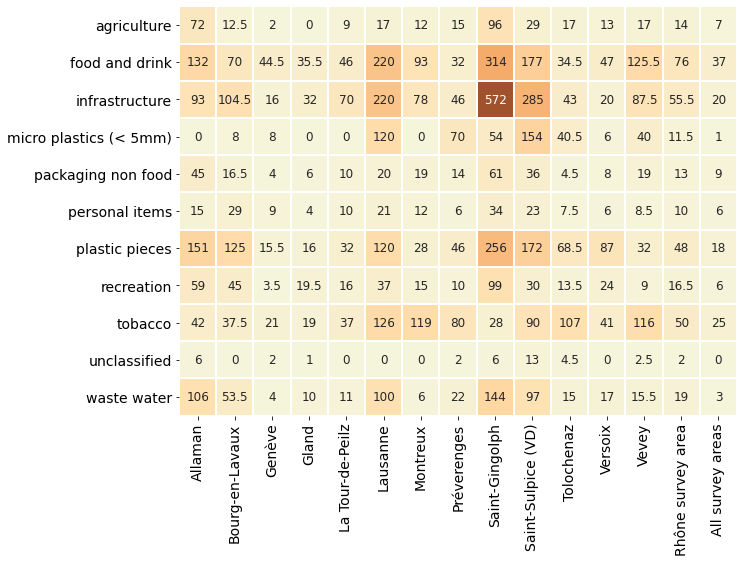

In [21]:
data_table = cg_t.pivot(columns=this_level, index='groupname', values=unit_label)

# repeat for the survey area
t_s_a = a_data[(a_data.river_bassin == this_bassin)].groupby(['loc_date','groupname'], as_index=False).agg(agg_pcs_quantity)
t_s_a = t_s_a.groupby('groupname', as_index=False).agg({unit_label:'median', 'quantity':'sum'})
t_s_a.set_index('groupname', inplace=True)
t_s_a[bassin_label] = t_s_a[unit_label]

# repeat for all the survey areas
a_s_a = a_data.groupby(['water_name_slug', 'loc_date','groupname'], as_index=False).agg(agg_pcs_quantity)
a_s_a = a_s_a.groupby('groupname', as_index=False)[unit_label].median()
a_s_a.set_index('groupname', inplace=True)
a_s_a[top] = a_s_a[unit_label]

# merge with data_table
data = pd.concat([data_table, t_s_a[bassin_label] , a_s_a[top]], axis=1)

fig, ax = plt.subplots(figsize=(10,10))

axone = ax
sns.heatmap(data , ax=axone, cmap=cmap2, annot=True, annot_kws={"fontsize":12}, fmt='g', cbar=False, linewidth=.1, square=True, linecolor='white')

axone.set_ylabel("")
axone.tick_params(labelsize=14, which='both', axis='both', labeltop=False, labelbottom=True)

plt.setp(axone.get_xticklabels(), rotation=90, fontsize=14)
plt.setp(axone.get_yticklabels(), rotation=0, fontsize=14)

plt.show()

## Annex

### Fragmented foams and plastics by size group

These are the components of Gfoam and Gfrags, objects labled "Expanded foams" are grouped with Gfoam the rest are grouped under Gfrags.

In [22]:
frag_foams = F"""
*{this_feature['name']} fragmented foams and plastics by size group.* 

*median {unit_label}, number of pieces, percent of total*
"""
md(frag_foams)


*Lac Léman fragmented foams and plastics by size group.* 

*median p/100m, number of pieces, percent of total*


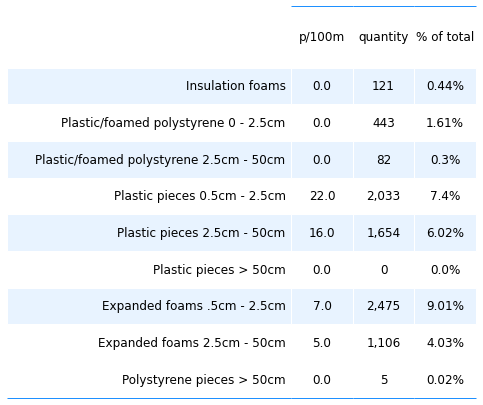

In [23]:
# collect the data before aggregating foams for all locations in the survye area
# Combine the different sizes of fragmented plastics and styrofoam
# the codes for the foams
some_foams = ['G81', 'G82', 'G83', 'G74']

# the codes for the fragmented plastics
some_frag_plas = list(before_agg[before_agg.groupname == 'plastic pieces'].code.unique())

fd_frags_foams = before_agg[(before_agg.code.isin([*some_frag_plas, *some_foams]))&(before_agg.location.isin(fd_locs))].groupby(['loc_date','code'], as_index=False).agg(agg_pcs_quantity)
fd_frags_foams = fd_frags_foams.groupby('code').agg({unit_label:'median', 'quantity':'sum'})

# add code description and format for printing
fd_frags_foams['item'] = fd_frags_foams.index.map(lambda x: code_description_map.loc[x])
fd_frags_foams['% of total'] = (fd_frags_foams.quantity/fd.quantity.sum()*100).round(2)
fd_frags_foams['% of total'] = fd_frags_foams['% of total'].map(lambda x: F"{x}%")
fd_frags_foams['quantity'] = fd_frags_foams['quantity'].map(lambda x: F"{x:,}")

# table data
data = fd_frags_foams[['item',unit_label, 'quantity', '% of total']]

fig, axs = plt.subplots(figsize=(len(data.columns)*2.1,len(data)*.8))
ut.hide_spines_ticks_grids(axs)

the_first_table_data = axs.table(data.values,  colLabels=data.columns, colWidths=[.6, .13, .13, .13], bbox=[0, 0, 1, 1])

a_summary_table_one = sut.make_a_summary_table(the_first_table_data,data.values,data.columns, a_color, s_et_bottom_row=True)

a_summary_table_one.get_celld()[(0,0)].get_text().set_text(" ")

plt.show()
plt.tight_layout()
plt.close()

### IQAASL surveyors

Hammerdirt staff:

1. Shannon Erismann, field operations manager
2. Thor Erismann, volunteer surveyor
3. Bettina Siegenthaler, surveyor
5. Roger Erismann, surveyor

Participating organizations:

1. Precious plastic leman
2. Association pour la Sauvegarde du Léman
3. Geneva international School
4. Solid waste management: École polytechnique fédéral Lausanne
5. Summit foundation
7. Hackuarium

__The survey locations__

In [24]:
# display the survey locations
pd.set_option('display.max_rows', None)
disp_columns = ['latitude', 'longitude', 'city']
disp_beaches = dfBeaches.loc[fd_locs][disp_columns]
disp_beaches

,latitude,longitude,city
slug,,,
maladaire,46.446296,6.876960,La Tour-de-Peilz
preverenges,46.512690,6.527657,Préverenges
vidy-ruines,46.516221,6.596279,Lausanne
baby-plage-geneva,46.208558,6.162923,Genève
grand-clos,46.387746,6.843686,Saint-Gingolph
quai-maria-belgia,46.460156,6.836718,Vevey
anarchy-beach,46.447216,6.859612,La Tour-de-Peilz
cully-plage,46.488887,6.741396,Bourg-en-Lavaux
preverenges-le-sout,46.508905,6.534526,Préverenges


### Inventory of items

In [25]:
pd.set_option('display.max_rows', None)
complete_inventory = code_totals[code_totals.quantity>0][['item', 'groupname', 'quantity','% of total','fail rate']]
complete_inventory.sort_values(by='quantity', ascending=False)

,item,groupname,quantity,% of total,fail rate
code,,,,,
Gfrags,Fragmented plastics,plastic pieces,4212,15.34,96
Gfoam,Expanded polystyrene,infrastructure,3586,13.06,83
G27,Cigarette filters,tobacco,3116,11.35,94
G30,"Food wrappers; candy, snacks",food and drink,1679,6.11,95
G112,Industrial pellets (nurdles),micro plastics (< 5mm),1387,5.05,46
G95,Cotton bud/swab sticks,waste water,1112,4.05,81
G74,Insulation foams,infrastructure,1112,4.05,77
G67,Industrial sheeting,agriculture,1058,3.85,77
G117,Expanded foams < 5mm,micro plastics (< 5mm),689,2.51,29
